In [3]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import model_selection, preprocessing
from operator import add, sub

sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=1))

In [29]:
class NN(object):

    def __init__(self, n_nodes):
        self.n_nodes = n_nodes
        self.n_layers = len(n_nodes)
        self.weights, self.bias = self.init_weights()
        
    def train(self, X, y, lr, epochs=100, batch_size=1):
        N = len(X)
        errors = []
        
        for e in np.arange(epochs):
            X, y = self.shuffle_data(X, y)
            
            X_batches = np.array(
                [X[k:k + batch_size] 
                 for k in np.arange(0, N, batch_size)])
            y_batches = np.array(
                [y[k:k + batch_size] 
                 for k in np.arange(0, N, batch_size)])
            
            for xb, yb in zip(X_batches, y_batches):
                self.update(xb, yb, lr)
            
            y_hat = self.feed_forward(X)
            errors.append(self.cross_entropy_ave(y, y_hat))
                
        plt.title('Loss Curve')
        plt.plot(errors)
        plt.show()


    # get final output of nn from input X based on current weights and biases
    # Assumes X a numpy representation  of the data in wide format. 
    def feed_forward(self, X, train=False):
        a = np.atleast_2d(X).T
        N = len(self.n_nodes)
        iters = np.arange(1, N)
        activations = [a]
        zs = []
        for i, b, w in zip(iters, self.bias, self.weights): 
            a = self.activate_logistic(a, w, b)
            if train:
                activations.append(a)
                zs.append(w @ activations[i - 1] + b)

        if train:
            return activations, zs
        return a
    
    def back_prop(self, X, Y, debug=False):
        del_w  = np.array([np.zeros(w.shape) for w in self.weights])
        del_b  = np.array([np.zeros(b.shape) for b in self.bias])
        
        # feed forward: 
        A, Z = self.feed_forward(X, train=True)
        
        # get error heuristic of output layer:
        delta_l = self.cost_derivative(Y, A[-1]) * self.sigmoid_prime(Z[-1])
        del_w[-1] = delta_l @ A[-2].T 
        del_b[-1] = delta_l
        
        # back propagate: 
        for i in np.arange(2, len(self.n_nodes)):
            sp = self.sigmoid_prime(Z[-i])
            delta_l    = (self.weights[-i + 1].T @ delta_l) * sp
            del_b[-i]  = delta_l
            del_w[-i]  = delta_l @ A[-i - 1].T 
            
        return del_w, del_b
    
    # helper functions --------------------
    def update(self, X, Y, lr):
        N = len(X)
        nabla_b = np.array([np.zeros(b.shape) for b in self.bias])
        nabla_w = np.array([np.zeros(w.shape) for w in self.weights])
        
        for x, y in zip(X, Y):
            delta_dw, delta_db = self.back_prop(x, y)
            nabla_w += delta_dw
            nabla_b += delta_db
        
        self.weights -= lr*np.array(list(map(lambda x: x / N, nabla_w)))
        self.bias    -= lr*np.array(list(map(lambda x: x / N, nabla_b)))
            
        
    def activate_logistic(self, X, weights, bias):
        return expit(weights @ X + bias)
    
    def activate_softmax(self, X, weights, bias):
        Z = weights @ X + b
        return np.exp(Z[i])/np.exp(Z).sum()
    
    def sigmoid_prime(self, X):
        return expit(X) * (1 - expit(X))
    
    # cross entropy loss derivative wrt final activation layer
    def cost_derivative(self, y, y_hat):
        return (y_hat - y) / (1e7 + y_hat * (1 - y_hat))

    def init_weights(self):
        weights = np.array([np.random.randn(m, n) for m, n in zip(self.n_nodes[1:], self.n_nodes[:-1])])
        bias = np.array([np.zeros(m).reshape(-1,1) for m in self.n_nodes[1:]])  
        return weights, bias
    
    def shuffle_data(self, X, y):
        N = len(X)
        idx = np.arange(N)
        np.random.shuffle(idx)
        return X[idx], y[idx]
    
    def cross_entropy_ave(self, y, y_hat):
        return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()
    
    # ------------------------------------
        

In [30]:
np.random.seed(44)
net = NN((3,2,1))

In [31]:
data = pd.read_csv('student_data.csv')
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [32]:
data = preprocessing.minmax_scale(data, feature_range=(0,1))
data

array([[0.        , 0.27586207, 0.77586207, 0.66666667],
       [1.        , 0.75862069, 0.81034483, 0.66666667],
       [1.        , 1.        , 1.        , 0.        ],
       ...,
       [0.        , 0.4137931 , 0.21264368, 0.33333333],
       [0.        , 0.82758621, 0.79885057, 0.33333333],
       [0.        , 0.65517241, 0.93678161, 0.66666667]])

In [33]:
X = data[:3, 1:]
y = data[:3, 0]

[[-0.75061472  1.31635732  1.24614003]
 [-1.60491574 -1.46814368 -1.71507046]]
[[1.85878369 0.08758798]]
[[0.]
 [0.]]
[[0.]]


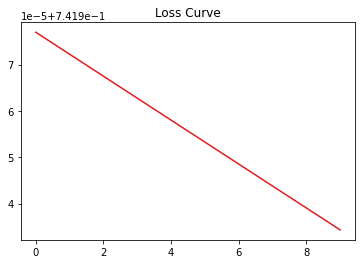

In [34]:
for w in net.weights:
    print(w)
for b in net.bias:
    print(b)
    
net.train(X, y, 10000, 10, 1)

In [35]:
for w in net.weights:
    print(w)
for b in net.bias:
    print(b)

[[-0.75056033  1.31636348  1.2460931 ]
 [-1.60491561 -1.46814453 -1.71507164]]
[[1.85861638 0.0875725 ]]
[[-1.06201035e-05]
 [-1.25507438e-06]]
[[-0.00016095]]


In [172]:
net.feed_forward(X)

array([[0.82680337, 0.81329256, 0.76658414]])